In [ ]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, LayerNormalization, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber
from sklearn.preprocessing import MinMaxScaler

BINANCE_BASE = "https://data-api.binance.vision"
SYMBOL = "BTCUSDT"
INTERVAL = "1m"

LIMIT = 4600
WINDOW = 120
FORECAST_MINUTES = 10


In [ ]:
url = f"{BINANCE_BASE}/api/v3/klines"
params = {"symbol": SYMBOL, "interval": INTERVAL, "limit": LIMIT}
data = requests.get(url, params=params).json()

df = pd.DataFrame(data, columns=[
    "open_time","open","high","low","close","volume",
    "close_time","qav","trades","tb","tq","ignore"
])

df["close"] = df["close"].astype(float)
df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
df = df[["open_time", "close"]]


In [ ]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[["close"]])

X, y = [], []
for i in range(WINDOW, len(scaled)):
    X.append(scaled[i-WINDOW:i])
    y.append(scaled[i])

X = np.array(X)
y = np.array(y)

X.shape, y.shape


((880, 120, 1), (880, 1))

In [ ]:
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]


In [ ]:
model = Sequential([
    Conv1D(64, kernel_size=3, padding="causal", activation="relu",
           kernel_regularizer=l2(0.0000001), input_shape=(WINDOW, 1)),
    LayerNormalization(),

    Conv1D(64, kernel_size=3, padding="causal", activation="relu",
           kernel_regularizer=l2(0.0000001)),
    LayerNormalization(),

    MaxPooling1D(pool_size=2),
    Dropout(0.15),

    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.0000001))),
    Dropout(0.2),
    LayerNormalization(),

    GRU(64, return_sequences=False, kernel_regularizer=l2(0.0000001)),
    Dropout(0.2),

    Dense(64, activation="relu", kernel_regularizer=l2(0.0000001)),
    Dropout(0.1),

    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.00003),
    loss=Huber(delta=1.0)
)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=32,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 0.6564 - val_loss: 0.0562
Epoch 2/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1216 - val_loss: 0.3940
Epoch 3/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0729 - val_loss: 0.3721
Epoch 4/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0647 - val_loss: 0.2996
Epoch 5/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0558 - val_loss: 0.2775
Epoch 6/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0576 - val_loss: 0.2803
Epoch 7/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0550 - val_loss: 0.2442
Epoch 8/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0546 - val_loss: 0.2540
Epoch 9/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0649 - val_loss: 0.2852
Epoch 10/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0555 - val_loss: 0.2201
Epoch 11/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0526 - val_loss: 0.2244
Epoch 12/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

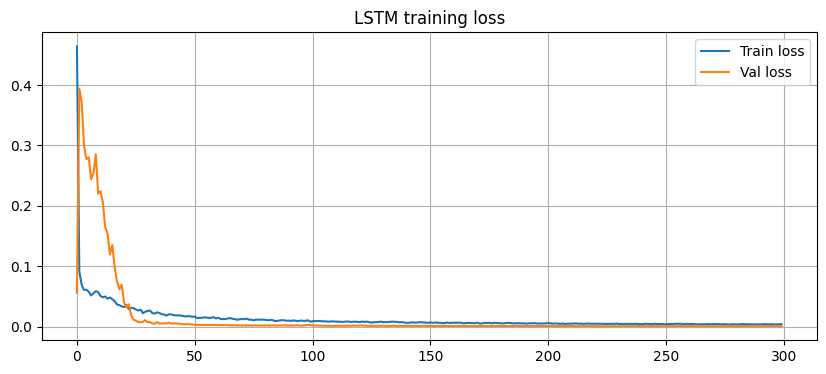

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.grid(True)
plt.legend()
plt.title("LSTM training loss")
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


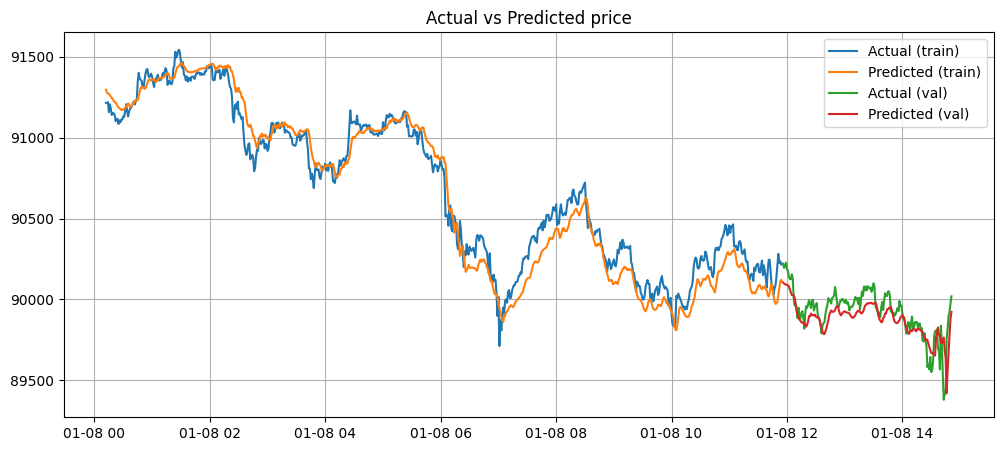

In [ ]:
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)

train_pred_inv = scaler.inverse_transform(train_pred)
y_train_inv = scaler.inverse_transform(y_train)

val_pred_inv = scaler.inverse_transform(val_pred)
y_val_inv = scaler.inverse_transform(y_val)

plt.figure(figsize=(12,5))
plt.plot(df["open_time"][WINDOW:split+WINDOW], y_train_inv, label="Actual (train)")
plt.plot(df["open_time"][WINDOW:split+WINDOW], train_pred_inv, label="Predicted (train)")
plt.plot(df["open_time"][split+WINDOW:], y_val_inv, label="Actual (val)")
plt.plot(df["open_time"][split+WINDOW:], val_pred_inv, label="Predicted (val)")
plt.legend()
plt.grid(True)
plt.title("Actual vs Predicted price")
plt.show()


In [ ]:
last_window = scaled[-WINDOW:].copy()
future_scaled = []

win_mean = float(np.mean(last_window))
win_std  = float(np.std(last_window) + 1e-8)

low_lim  = win_mean - 2.0 * win_std
high_lim = win_mean + 2.0 * win_std

for _ in range(FORECAST_MINUTES):
    pred = float(model.predict(last_window.reshape(1, WINDOW, 1), verbose=0)[0, 0])

    pred = max(low_lim, min(high_lim, pred))

    future_scaled.append(pred)

    last_window = np.vstack([last_window[1:], [[pred]]])

future_prices = scaler.inverse_transform(np.array(future_scaled).reshape(-1, 1)).flatten()


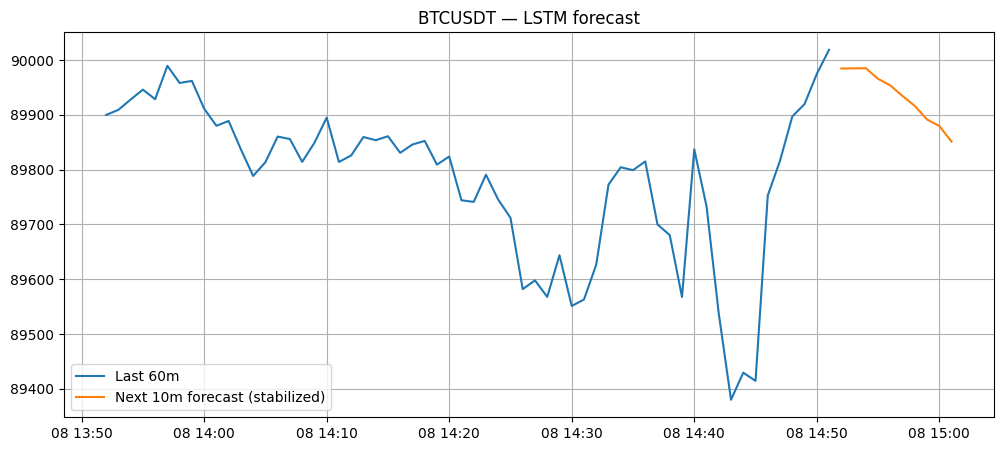

In [ ]:
history_df = df.tail(60)
future_times = pd.date_range(
    start=history_df["open_time"].iloc[-1] + pd.Timedelta(minutes=1),
    periods=FORECAST_MINUTES,
    freq="1min"
)

plt.figure(figsize=(12,5))
plt.plot(history_df["open_time"], history_df["close"], label="Last 60m")
plt.plot(future_times, future_prices, label="Next 10m forecast (stabilized)")
plt.grid(True)
plt.legend()
plt.title("BTCUSDT — LSTM forecast")
plt.show()